In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.experimental.ode import odeint
import numpy as np
import matplotlib.pyplot as plt
import optax

from flax import linen as nn
from flax.training import train_state
from jax import random

In [2]:
import sys
import os

path_ = os.path.abspath(os.path.join('..', 'utils'))

# Add the directory to sys.path
if path_ not in sys.path:
    sys.path.append(path_)

from non_parametric_collocation import collocate_data
from interpolation import BarycentricInterpolation
from data_generation import generate_ode_data

In [3]:
class NeuralODE(nn.Module):
    layer_widths: list

    @nn.compact
    def __call__(self, x):
        # all but last
        for width in self.layer_widths[:-1]:
            x = nn.Dense(width)(x)
            x = nn.tanh(x)
        # only the last layer
        x = nn.Dense(self.layer_widths[-1])(x)
        return x
    
def create_train_state(rng, layer_widths, learning_rate):
    # initialize
    model = NeuralODE(layer_widths=layer_widths)
    params = model.init(rng, jnp.ones((2,)))['params']
    tx = optax.adam(learning_rate)
    # return a TrainState object
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

    
def loss_fn(params, apply_fn, t, observed_data, y0):
    # func represents the ODE system
    # required to create a callable for odeint
    def func(y, t):
        # apply_fn is function to apply the model
        return apply_fn({'params': params}, y)
    pred_solution = odeint(func, y0, t)
    # odeint will call func(y, t) multiple times
    return jnp.mean(jnp.abs(pred_solution - observed_data))

@jax.jit
def train_step(state, t, observed_data, y0):
    """
    Perform a single training step
    """
    # construct a function that computes both loss and its gradients wrt model parameters
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params, state.apply_fn, t, observed_data, y0)
    
    # update model parameters
    state = state.apply_gradients(grads=grads)
    return state, loss

def train(state, t, observed_data, y0, num_epochs=1000):
    for epoch in range(num_epochs):
        state, loss = train_step(state, t, observed_data, y0)
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss}')
    return state

In [5]:
n_points = 200
noise_level = 0.2
ode_type = "harmonic_oscillator"
params = {"omega_squared": 4}
start_time=0
end_time=10
spacing_type="equally_spaced"
initial_state = jnp.array([0.0, 1.0])

t, y, y_noisy, true_derivatives = generate_ode_data(n_points, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

spacing_type="chebyshev"
t_cheb, y_cheb, y_noisy_cheb, true_derivatives_cheb = generate_ode_data(n_points, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

In [6]:
print(collocate_data.__doc__)

Applies the kernel-based collocation method to smooth data.

    Args:
        data (jax.numpy.ndarray): The noisy data array.
        tpoints (jax.numpy.ndarray): The array of time points.
        kernel (str, optional): The type of kernel to use ("EpanechnikovKernel" or "TriangularKernel").
        bandwidth (float, optional): The bandwidth for the kernel. If None, it is calculated automatically. Defaults to None.

    Returns:
        tuple: The estimated derivatives and smoothed solutions.
    


In [16]:
estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'EpanechnikovKernel', bandwidth=0.6)
estimated_derivative_cheb, estimated_solution_cheb = collocate_data(y_noisy_cheb, t_cheb, 'EpanechnikovKernel', bandwidth=0.6)

Loss equal: 24.109
Loss Chebyshev: 35.137


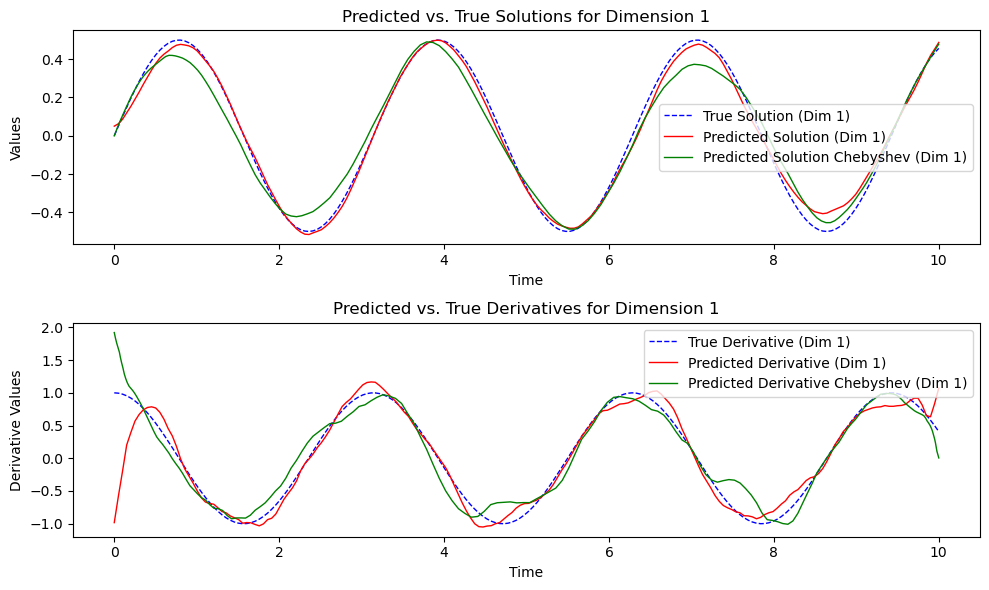

In [18]:
plt.figure(figsize=(10, 6))

# Subplot 1: Solutions
plt.subplot(2, 1, 1)  
plt.plot(t, y[:, 0], 'b--', linewidth=1, label='True Solution (Dim 1)')
plt.plot(t, estimated_solution[0], 'r-', linewidth=1, label='Predicted Solution (Dim 1)')
plt.plot(t_cheb, estimated_solution_cheb[0], 'g-', linewidth=1, label='Predicted Solution Chebyshev (Dim 1)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Predicted vs. True Solutions for Dimension 1')
plt.legend()

# Subplot 2: Derivatives
plt.subplot(2, 1, 2)  
plt.plot(t, true_derivatives[:, 0], 'b--', linewidth=1, label='True Derivative (Dim 1)')
plt.plot(t, estimated_derivative[0], 'r-', linewidth=1, label='Predicted Derivative (Dim 1)')
plt.plot(t_cheb, estimated_derivative_cheb[0], 'g-', linewidth=1, label='Predicted Derivative Chebyshev (Dim 1)')
plt.xlabel('Time')
plt.ylabel('Derivative Values')
plt.title('Predicted vs. True Derivatives for Dimension 1')
plt.legend()

print(f"Loss equal: {jnp.sum(jnp.abs(true_derivatives.T[0] - estimated_derivative[0])):.3f}")
print(f"Loss Chebyshev: {jnp.sum(jnp.abs(true_derivatives_cheb.T[0] - estimated_derivative_cheb[0])):.3f}")

plt.tight_layout() 
plt.show()


Loss equal: 37.521
Loss Chebyshev: 39.437


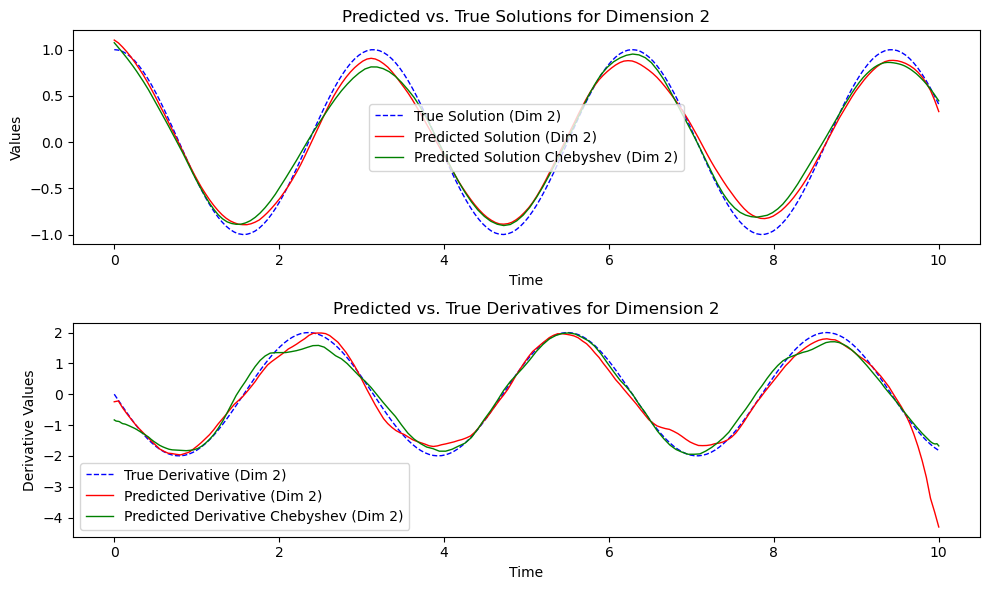

In [19]:
plt.figure(figsize=(10, 6))

# Subplot 1: Solutions
plt.subplot(2, 1, 1)  
plt.plot(t, y[:, 1], 'b--', linewidth=1, label='True Solution (Dim 2)')
plt.plot(t, estimated_solution[1], 'r-', linewidth=1, label='Predicted Solution (Dim 2)')
plt.plot(t_cheb, estimated_solution_cheb[1], 'g-', linewidth=1, label='Predicted Solution Chebyshev (Dim 2)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Predicted vs. True Solutions for Dimension 2')
plt.legend()

# Subplot 2: Derivatives
plt.subplot(2, 1, 2)  
plt.plot(t, true_derivatives[:, 1], 'b--', linewidth=1, label='True Derivative (Dim 2)')
plt.plot(t, estimated_derivative[1], 'r-', linewidth=1, label='Predicted Derivative (Dim 2)')
plt.plot(t_cheb, estimated_derivative_cheb[1], 'g-', linewidth=1, label='Predicted Derivative Chebyshev (Dim 2)')
plt.xlabel('Time')
plt.ylabel('Derivative Values')
plt.title('Predicted vs. True Derivatives for Dimension 2')
plt.legend()

print(f"Loss equal: {jnp.sum(jnp.abs(true_derivatives.T[1] - estimated_derivative[1])):.3f}")
print(f"Loss Chebyshev: {jnp.sum(jnp.abs(true_derivatives_cheb.T[1] - estimated_derivative_cheb[1])):.3f}")

plt.tight_layout() 
plt.show()


In [37]:
# Helper function to obtain the solution
def neural_ode(params, y0, t, state):
    def func(y, t):
        return state.apply_fn({'params': params}, y)
    return odeint(func, y0, t)

### Regular Neural ODE

In [12]:
layer_widths = [2, 100, 100, 2]
rng = random.PRNGKey(0)
learning_rate = 1e-3

y0 = jnp.array([0.0, 1.0])
state = create_train_state(rng, layer_widths, learning_rate)

In [13]:
state.__dict__.keys()

dict_keys(['step', 'apply_fn', 'params', 'tx', 'opt_state'])

In [14]:
state.__dict__['apply_fn']

<bound method Module.apply of NeuralODE(
    # attributes
    layer_widths = [2, 100, 100, 2]
)>

In [15]:
layer_widths = [2, 100, 100, 2]
rng = random.PRNGKey(0)
learning_rate = 1e-3

y0 = jnp.array([0.0, 1.0])
state = create_train_state(rng, layer_widths, learning_rate)
trained_state = train(state, t, y_noisy, y0)

Epoch 0, Loss: 1.6541759967803955
Epoch 100, Loss: 0.48866549134254456
Epoch 200, Loss: 0.4846652150154114
Epoch 300, Loss: 0.47599512338638306
Epoch 400, Loss: 0.48714759945869446
Epoch 500, Loss: 0.4746343493461609
Epoch 600, Loss: 0.44636964797973633
Epoch 700, Loss: 0.3082658648490906
Epoch 800, Loss: 0.16305933892726898
Epoch 900, Loss: 0.16031837463378906


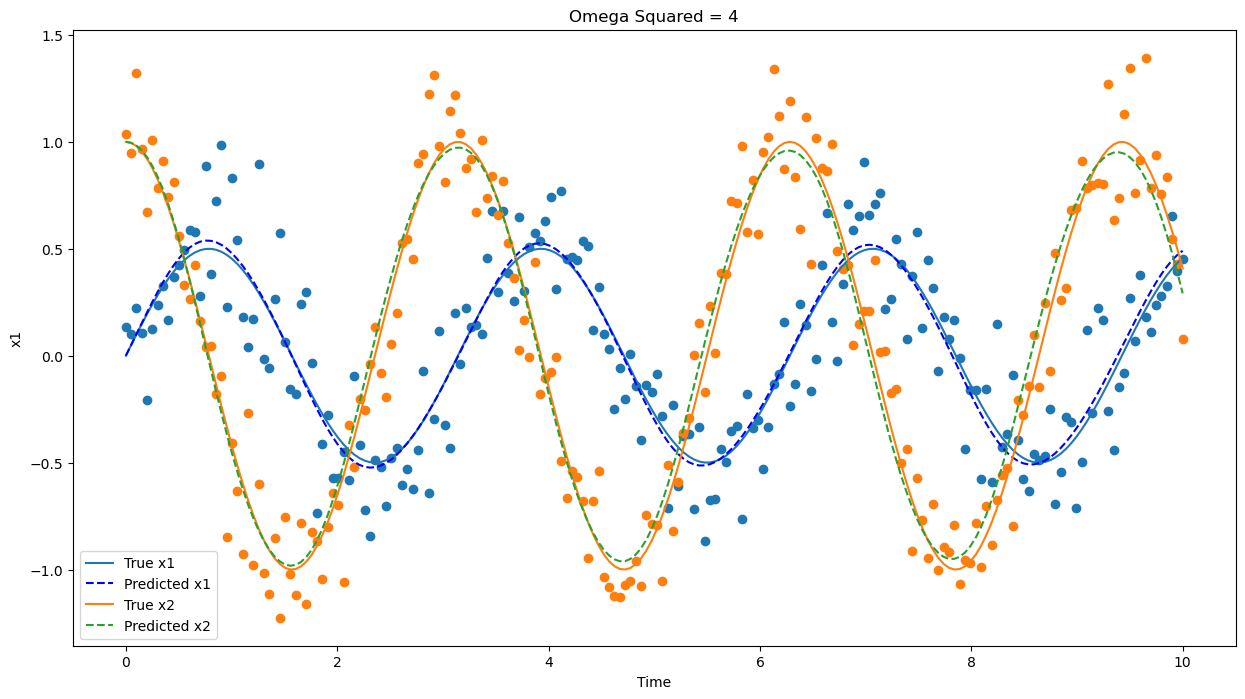

In [16]:
y0 = jnp.array([0.0, 1.0])
y_pred = neural_ode(trained_state.params, y0, t, trained_state)

plt.figure(figsize=(15, 8))
plt.plot(t, y[:, 0], label='True x1')
plt.scatter(t, y_noisy[:, 0])
plt.plot(t, y_pred[:, 0], 'b--', label='Predicted x1')
plt.plot(t, y[:, 1], label='True x2')
plt.plot(t, y_pred[:, 1], '--', label='Predicted x2')
plt.scatter(t, y_noisy[:, 1])
plt.xlabel('Time')
plt.ylabel('x1')
plt.legend()
plt.title(f'Omega Squared = {params["omega_squared"]}')
plt.show()


## Collocation Based NODE

In [38]:
from jax import jit, value_and_grad
    
class NeuralODE_Collocation(nn.Module):
    layer_widths: list

    @nn.compact
    def __call__(self, x):
        for width in self.layer_widths[:-1]:
            x = nn.Dense(width)(x)
            x = nn.tanh(x)
        x = nn.Dense(self.layer_widths[-1])(x)
        return x
    
    
def create_train_state(rng, layer_widths, input_shape, learning_rate):
    model = NeuralODE_Collocation(layer_widths=layer_widths)
    params = model.init(rng, jnp.ones(input_shape))['params']
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)


def loss_fn_collocation(params, apply_fn, t, observed_derivative):
    """
    Compute the loss as the mean squared error between predicted derivatives
    and observed derivatives.
    
    Args:
        params (dict): Parameters of the model.
        apply_fn (function): Function to apply the model to input data.
        t (jax.numpy.ndarray): Input features; typically, the time points or other relevant features.
        observed_derivative (jax.numpy.ndarray): True derivatives at the input features.
    
    Returns:
        float: The mean squared error loss.
    """
    # Predict derivatives using the neural network
    # print(f"t.shape:{t.shape}")
    pred_derivative = apply_fn({'params': params}, t)

    return jnp.mean(jnp.abs(pred_derivative - observed_derivative))


def loss_fn_collocation(params, apply_fn, t, observed_derivative):
    # Predict derivatives for each data point in t
    def nn_forward(params, x):
        return apply_fn({'params': params}, x)
    
    pred_derivative = []
    for data_point in t:
        derivative = nn_forward(params, data_point.reshape(1, -1))
        pred_derivative.append(derivative)
    
    pred_derivative = jnp.concatenate(pred_derivative, axis=0)
    return jnp.mean(jnp.abs(pred_derivative - observed_derivative))

@jit
def train_step_collocation(state, t, observed_derivative):
    """
    Perform a single training step by computing the loss and its gradients,
    and then updating the model parameters.

    Args:
        state (TrainState object): Contains model state including parameters.
        t (jax.numpy.ndarray): Input features for the model.
        observed_derivative (jax.numpy.ndarray): True derivatives to compare against model predictions.

    Returns:
        tuple: Updated state and loss value.
    """
    def loss_fn(params):
        return loss_fn_collocation(params, state.apply_fn, t, observed_derivative)
    # Construct a function that computes both loss and its gradients wrt model parameters
    
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss

def train_collocation(state, t, observed_data, num_epochs=1000):
    for epoch in range(num_epochs):
        state, loss = train_step_collocation(state, t, observed_data)
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {loss}')
    return state

In [39]:
layer_widths = [2, 100, 100, 2]
rng = random.PRNGKey(0)
learning_rate = 1e-3

input_shape = (2, )
state_coll = create_train_state(rng, layer_widths, input_shape, learning_rate)
trained_state_collocoation = train_collocation(state_coll, jnp.array([t, t]).T, estimated_derivative.T, num_epochs= 10000)

Epoch 0, Loss: 0.9712858200073242
Epoch 1000, Loss: 0.5304688811302185
Epoch 2000, Loss: 0.41138729453086853
Epoch 3000, Loss: 0.26811084151268005
Epoch 4000, Loss: 0.13233792781829834
Epoch 5000, Loss: 0.09237053990364075
Epoch 6000, Loss: 0.058566462248563766
Epoch 7000, Loss: 0.04347389191389084
Epoch 8000, Loss: 0.03828584402799606
Epoch 9000, Loss: 0.04185531660914421


In [24]:
# pred_derivative = apply_fn({'params': params}, t)
def predict_derivatives(state, t):
    pred_dy_dt = []
    # sn
    for i in range(len(t)):
        dy_dt = state.apply_fn({'params': state.params}, t[i])
        pred_dy_dt.append(dy_dt)
    return jnp.array(pred_dy_dt)

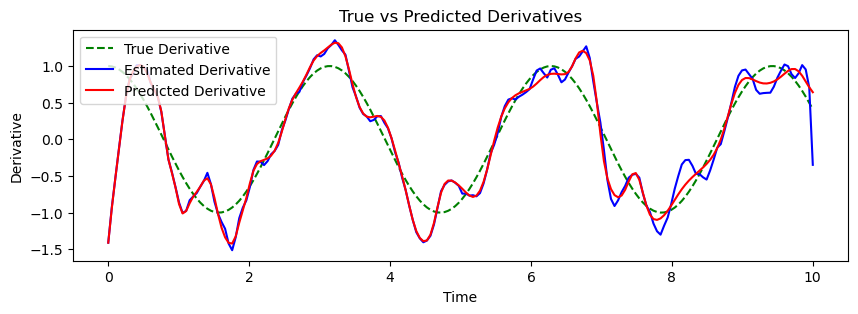

In [25]:
pred_dy_dt = predict_derivatives(trained_state_collocoation, jnp.array([t, t]).T)

# Plot true vs predicted derivatives
plt.figure(figsize=(10, 3))
plt.plot(t, true_derivatives.T[0], label='True Derivative', color='green', linestyle='dashed')
plt.plot(t, estimated_derivative[0], label='Estimated Derivative', color='blue')
plt.plot(t, pred_dy_dt.T[0], label='Predicted Derivative', color='red')
plt.xlabel('Time')
plt.ylabel('Derivative')
plt.title('True vs Predicted Derivatives')
plt.legend()
plt.show()

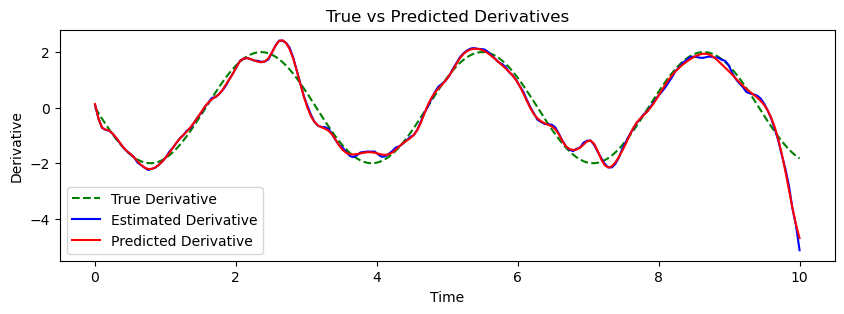

In [26]:
# Plot true vs predicted derivatives
plt.figure(figsize=(10, 3))
plt.plot(t, true_derivatives.T[1], label='True Derivative', color='green', linestyle='dashed')
plt.plot(t, estimated_derivative[1], label='Estimated Derivative', color='blue')
plt.plot(t, pred_dy_dt.T[1], label='Predicted Derivative', color='red')
plt.xlabel('Time')
plt.ylabel('Derivative')
plt.title('True vs Predicted Derivatives')
plt.legend()
plt.show()

In [30]:
def integrate_derivative(t, dy_dt, y0):
    y = jnp.zeros_like(dy_dt)
    y = y.at[0].set(y0)
    for i in range(1, len(dy_dt)):
        dt = t[i] - t[i - 1]
        y = y.at[i].set(y[i - 1] + dy_dt[i - 1] * dt)
    return y

# Reconstruct the function from the predicted derivatives
y0 = y[0]  # Initial condition
y_pred = integrate_derivative(t, pred_dy_dt, y0)

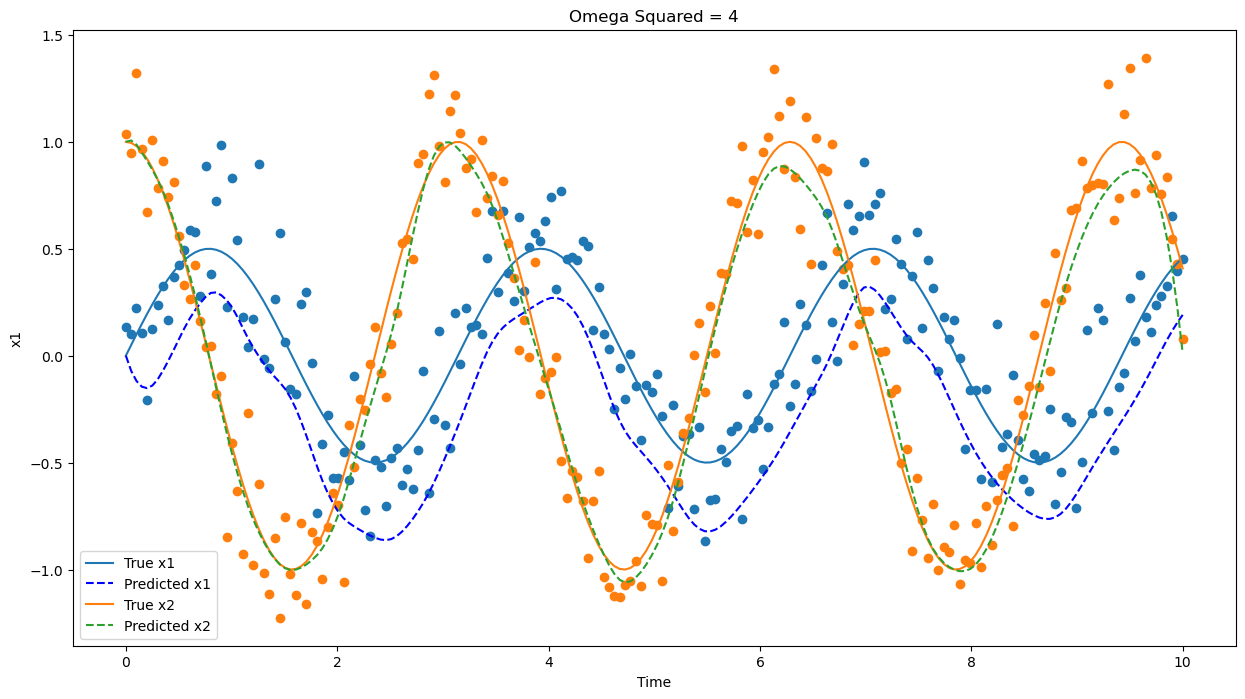

In [31]:
plt.figure(figsize=(15, 8))
plt.plot(t, y[:, 0], label='True x1')
plt.scatter(t, y_noisy[:, 0])
plt.plot(t, y_pred[:, 0], 'b--', label='Predicted x1')
plt.plot(t, y[:, 1], label='True x2')
plt.plot(t, y_pred[:, 1], '--', label='Predicted x2')
plt.scatter(t, y_noisy[:, 1])
plt.xlabel('Time')
plt.ylabel('x1')
plt.legend()
plt.title(f'Omega Squared = {params["omega_squared"]}')
plt.show()
